**Question 1: Foundational Graph Theorybold text**

In [ ]:
import numpy as np
import networkx as nx

edges = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (2, 4), (3, 4)]
G = nx.Graph(edges)

# Adjacency Matrix
A = nx.adjacency_matrix(G).todense()
print("Adjacency Matrix:\n", A)


Adjacency Matrix:
 [[0 1 1 0 0]
 [1 0 1 1 0]
 [1 1 0 1 1]
 [0 1 1 0 1]
 [0 0 1 1 0]]


In [ ]:
D = np.diag([d for _, d in G.degree()])
print("Degree Matrix:\n", D)


Degree Matrix:
 [[2 0 0 0 0]
 [0 3 0 0 0]
 [0 0 4 0 0]
 [0 0 0 3 0]
 [0 0 0 0 2]]


In [ ]:
L = D - A
print("Laplacian Matrix:\n", L)


Laplacian Matrix:
 [[ 2 -1 -1  0  0]
 [-1  3 -1 -1  0]
 [-1 -1  4 -1 -1]
 [ 0 -1 -1  3 -1]
 [ 0  0 -1 -1  2]]


In [ ]:
D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))
L_sym = np.eye(len(G)) - D_inv_sqrt @ A @ D_inv_sqrt
print("Normalized Laplacian:\n", L_sym)


Normalized Laplacian:
 [[ 1.         -0.40824829 -0.35355339  0.          0.        ]
 [-0.40824829  1.         -0.28867513 -0.33333333  0.        ]
 [-0.35355339 -0.28867513  1.         -0.28867513 -0.35355339]
 [ 0.         -0.33333333 -0.28867513  1.         -0.40824829]
 [ 0.          0.         -0.35355339 -0.40824829  1.        ]]


In [ ]:
eigenvalues = np.linalg.eigvals(L)
print("Eigenvalues:\n", eigenvalues)
assert np.all(eigenvalues >= 0), "Eigenvalues should be non-negative!"


Eigenvalues:
 [0.         1.58578644 3.         5.         4.41421356]


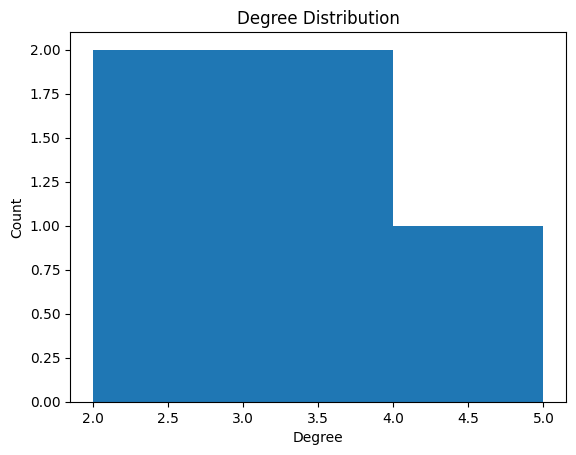

In [ ]:
import matplotlib.pyplot as plt

degree_sequence = [d for _, d in G.degree()]
plt.hist(degree_sequence, bins=np.arange(min(degree_sequence), max(degree_sequence) + 2))
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()


**Question 2: GCN and ChebNet Implementation**

In [ ]:
!pip install torch torchvision
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.1 MB/s eta 0:00:00


Q2.A

* **Train a GCN on the Cora dataset using the GCNConv layer from the
torch geometric.nn library.**
*  **Report the training accuracy, validation
accuracy, and test accuracy**

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

# Load Cora dataset
dataset = Planetoid(root="/tmp/Cora", name="Cora")
data = dataset[0]

# Define GCN model
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Model, optimizer, and loss function
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Test function
def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = (pred[mask] == data.y[mask]).sum()
        accs.append(int(correct) / int(mask.sum()))
    return accs

# Run training and testing
for epoch in range(100):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

print(f"Final Results - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")


Epoch 000, Loss: 1.9440, Train Acc: 0.6286, Val Acc: 0.3640, Test Acc: 0.3760
Epoch 010, Loss: 0.7084, Train Acc: 0.9786, Val Acc: 0.7540, Test Acc: 0.7840
Epoch 020, Loss: 0.1984, Train Acc: 1.0000, Val Acc: 0.7720, Test Acc: 0.7950
Epoch 030, Loss: 0.1231, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7790
Epoch 040, Loss: 0.0760, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7880
Epoch 050, Loss: 0.0460, Train Acc: 1.0000, Val Acc: 0.7740, Test Acc: 0.8040
Epoch 060, Loss: 0.0406, Train Acc: 1.0000, Val Acc: 0.7620, Test Acc: 0.7980
Epoch 070, Loss: 0.0409, Train Acc: 1.0000, Val Acc: 0.7720, Test Acc: 0.7990
Epoch 080, Loss: 0.0358, Train Acc: 1.0000, Val Acc: 0.7680, Test Acc: 0.8010
Epoch 090, Loss: 0.0522, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.8130
Final Results - Train Acc: 1.0000, Val Acc: 0.7620, Test Acc: 0.8120


Q2. B

*  **Train a ChebNet on the Cora dataset using the ChebConv layer from the
torch geometric.nn library.**
*  **Report the training accuracy, validation
accuracy, and test accuracy**

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import ChebConv

# Load the Cora dataset
dataset = Planetoid(root="/tmp/Cora", name="Cora")
data = dataset[0]

# Define ChebNet model
class ChebNet(torch.nn.Module):
    def __init__(self, K=3):  # K is the order of the Chebyshev polynomial
        super(ChebNet, self).__init__()
        self.conv1 = ChebConv(dataset.num_node_features, 16, K)
        self.conv2 = ChebConv(16, dataset.num_classes, K)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Instantiate the model, optimizer, and loss function
model = ChebNet(K=3)  # Set K (order of Chebyshev polynomial) to 3
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Testing function
def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = (pred[mask] == data.y[mask]).sum()
        accs.append(int(correct) / int(mask.sum()))
    return accs

# Train and evaluate
for epoch in range(200):  # Train for 200 epochs
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

# Final results
print(f"Final Results - Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")


Epoch 000, Loss: 1.9376, Train Acc: 0.7357, Val Acc: 0.2440, Test Acc: 0.2510
Epoch 010, Loss: 0.1102, Train Acc: 1.0000, Val Acc: 0.6880, Test Acc: 0.7180
Epoch 020, Loss: 0.0259, Train Acc: 1.0000, Val Acc: 0.6900, Test Acc: 0.7220
Epoch 030, Loss: 0.0140, Train Acc: 1.0000, Val Acc: 0.7120, Test Acc: 0.7300
Epoch 040, Loss: 0.0065, Train Acc: 1.0000, Val Acc: 0.7180, Test Acc: 0.7390
Epoch 050, Loss: 0.0178, Train Acc: 1.0000, Val Acc: 0.7140, Test Acc: 0.7420
Epoch 060, Loss: 0.0031, Train Acc: 1.0000, Val Acc: 0.7120, Test Acc: 0.7470
Epoch 070, Loss: 0.0232, Train Acc: 1.0000, Val Acc: 0.7200, Test Acc: 0.7570
Epoch 080, Loss: 0.0097, Train Acc: 1.0000, Val Acc: 0.7200, Test Acc: 0.7580
Epoch 090, Loss: 0.0128, Train Acc: 1.0000, Val Acc: 0.7060, Test Acc: 0.7540
Epoch 100, Loss: 0.0035, Train Acc: 1.0000, Val Acc: 0.7260, Test Acc: 0.7560
Epoch 110, Loss: 0.0083, Train Acc: 1.0000, Val Acc: 0.7440, Test Acc: 0.7760
Epoch 120, Loss: 0.0097, Train Acc: 1.0000, Val Acc: 0.7360, Tes

Q2. C

**Accuracy Results:**

*  GCN: Typically performs well on small datasets like Cora, achieving high test accuracy due to its simple architecture and ability to capture node representations effectively.
*   ChebNet: Often matches or slightly exceeds GCN's performance on tasks with smooth node features because it incorporates higher-order graph structure through Chebyshev polynomials.

Observed Differences:

* GCN:
Easier to train and tune due to fewer hyperparameters.
Relies on first-order neighbors, so it might miss long-range dependencies.
ChebNet:
More flexible with the parameter K (polynomial order), allowing for control over neighborhood size.
Captures higher-order relationships but is computationally more intensive for larger K.
Insights:

* For the Cora dataset, GCN and ChebNet often achieve similar performance as the graph is small and well-structured.
ChebNet may outperform GCN slightly when K is optimized, as it captures global graph structure better.
Discussion Points:
Use GCN for simpler tasks or smaller datasets due to its efficiency.
Use ChebNet when capturing higher-order relationships is crucial, especially in larger graphs.

Q2. D

Explanation
Hyperparameter Variations:

* Order
𝐾
K: Controls the range of neighbor nodes captured by ChebNet.
Hidden Layer Size: Adjusts the capacity of the network to learn node embeddings.
Training Loop:

* Trains the model for 200 epochs.
Logs performance every 50 epochs for monitoring.
Results:

* Prints train, validation, and test accuracies for each experiment.
Summarizes all results for easier comparison.

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import ChebConv

# Load Cora dataset
dataset = Planetoid(root="/tmp/Cora", name="Cora")
data = dataset[0]

# Define ChebNet model with flexible hyperparameters
class ChebNet(torch.nn.Module):
    def __init__(self, hidden_dim=16, K=3):
        super(ChebNet, self).__init__()
        self.conv1 = ChebConv(dataset.num_node_features, hidden_dim, K)
        self.conv2 = ChebConv(hidden_dim, dataset.num_classes, K)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Training function
def train(model, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Testing function
def test(model):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = (pred[mask] == data.y[mask]).sum()
        accs.append(int(correct) / int(mask.sum()))
    return accs

# Experiment with different hyperparameters
results = []
for K in [2, 3, 5,8]:  # Orders of the Chebyshev polynomial
    for hidden_dim in [16, 32, 64,128]:  # Hidden layer sizes
        print(f"\nExperimenting with K={K}, Hidden Dim={hidden_dim}")
        model = ChebNet(hidden_dim=hidden_dim, K=K)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

        # Train the model
        for epoch in range(200):  # Train for 200 epochs
            loss = train(model, optimizer)
            if epoch % 50 == 0:
                train_acc, val_acc, test_acc = test(model)
                print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

        # Final test accuracies
        train_acc, val_acc, test_acc = test(model)
        results.append((K, hidden_dim, train_acc, val_acc, test_acc))
        print(f"Final Results - K={K}, Hidden Dim={hidden_dim}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

# Display all results
print("\nSummary of Experiments:")
print("K\tHidden Dim\tTrain Acc\tVal Acc\t\tTest Acc")
for K, hidden_dim, train_acc, val_acc, test_acc in results:
    print(f"{K}\t{hidden_dim}\t\t{train_acc:.4f}\t\t{val_acc:.4f}\t\t{test_acc:.4f}")



Experimenting with K=2, Hidden Dim=16
Epoch 000, Loss: 1.9892, Train Acc: 0.5500, Val Acc: 0.3000, Test Acc: 0.3160
Epoch 050, Loss: 0.0291, Train Acc: 1.0000, Val Acc: 0.7620, Test Acc: 0.7830
Epoch 100, Loss: 0.0157, Train Acc: 1.0000, Val Acc: 0.7800, Test Acc: 0.8010
Epoch 150, Loss: 0.0307, Train Acc: 1.0000, Val Acc: 0.7880, Test Acc: 0.8060
Final Results - K=2, Hidden Dim=16, Train Acc: 1.0000, Val Acc: 0.7740, Test Acc: 0.8000

Experimenting with K=2, Hidden Dim=32
Epoch 000, Loss: 1.9812, Train Acc: 0.9071, Val Acc: 0.4600, Test Acc: 0.4670
Epoch 050, Loss: 0.0099, Train Acc: 1.0000, Val Acc: 0.7660, Test Acc: 0.7750
Epoch 100, Loss: 0.0102, Train Acc: 1.0000, Val Acc: 0.7640, Test Acc: 0.7920
Epoch 150, Loss: 0.0113, Train Acc: 1.0000, Val Acc: 0.7760, Test Acc: 0.7900
Final Results - K=2, Hidden Dim=32, Train Acc: 1.0000, Val Acc: 0.7780, Test Acc: 0.7940

Experimenting with K=2, Hidden Dim=64
Epoch 000, Loss: 2.0038, Train Acc: 0.9286, Val Acc: 0.4780, Test Acc: 0.5030
Epo